In [2]:
from lbmpy.session import *
from lbmpy.relaxationrates import *

# Tutorial 05: Modifying a LBM method: Smagorinsky model

In this demo, we show how to modify a lattice Boltzmann method. As example we are going to add a simple turbulence model, by introducing a rule that locally computes the relaxation parameter dependent on the local strain rate tensor. The Smagorinsky model is implemented directly in *lbmpy* as well, however here we take the manual approach to demonstrate how a LB method can be changed in *lbmpy*.

## 1) Theoretical background

Since we have *sympy* available, we want to start out with the basic model equations and derive the concrete equations ourselves. This approach is less error prone, since the calculations are done by the computer algebra system, and oftentimes this approach is also more general and easier to understand. 

### a) Smagorinsky model 

The basic idea of the Smagorinsky turbulence model is to safe compute time, by not resolving the smallest eddies of the flow on the grid, but model them by an artifical dissipation term. 
The energy dissipation of small scale vortices is taken into account by introducing a "turbulent viscosity". This additional viscosity depends on local flow properties, namely the local shear rates. The larger the local shear rates the higher the turbulent viscosity and the more artifical dissipation is added. 

The total viscosity is 

$$\nu_{total} = \nu_0 + \underbrace{(C_S \Delta)^2 |S|}_{\nu_{t}}$$

where $\nu_0$ is the normal viscosity, $C_S$ is the Smagorinsky constant, not to be confused with the speed of sound! Typical values of the Smagorinsky constant are between 0.1 - 0.2. The filter length $\Delta$ is chosen as 1 in lattice coordinates.

The quantity $|S|$ is computed from the local strain rate tensor $S$ that is given by

$$S_{ij} = \frac{1}{2} \left( \partial_i u_j + \partial_j u_i \right)$$

and 

$$|S| = \sqrt{2 S_{ij} S_{ij}}$$


### b) LBM implementation of Smagorinsky model

To add the Smagorinsky model to a LB scheme one has to first compute the strain rate tensor $S_{ij}$ in each cell, and compute the turbulent viscosity $\nu_t$ from it. Then the local relaxation rate has to be adapted to match the total viscosity $\nu_{total}$ instead of the standard viscosity $\nu_0$.

A fortunate property of LB methods is, that the strain rate tensor can be computed locally from the non-equilibrium part of the distribution function. This is somewhat surprising, since the strain rate tensor contains first order derivatives. The strain rate tensor can be obtained by

$$S_{ij} = - \frac{3 \omega_s}{2 \rho_{(0)}} \Pi_{ij}^{(neq)}$$

where $\omega_s$ is the relaxation rate that determines the viscosity, $\rho_{(0)}$ is $\rho$ in compressible models and $1$ for incompressible schemes.
$\Pi_{ij}^{(neq)}$ is the second order moment tensor of the non-equilibrium part of the distribution functions $f^{(neq)} = f - f^{(eq)}$ and can be computed as 

$$\Pi_{ij}^{(neq)} = \sum_q c_{qi} c_{qj} \; f_q^{(neq)}$$


We first have to find a closed form for $S_{ij}$ since in the formula above, it depends on $\omega$, which should be adapated according to $S_{ij}$. 
So we compute $\omega$ and insert it into the formula for $S$:
 

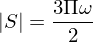

In [3]:
τ_0, ρ, ω, ω_total, ω_0 = sp.symbols("tau_0 rho omega omega_total omega_0", positive=True, real=True)
ν_0, C_S, S, Π = sp.symbols("nu_0, C_S, |S|, Pi", positive=True, real=True)

Seq = sp.Eq(S, 3 * ω / 2 * Π)
Seq

Note that we left of the minus, since we took the absolute value of both tensor. The absolute value is defined as above, with the factor of two inside the square root. The $\rho_{(0)}$ has been left out, remembering that $\Pi^{(neq)}$ has to be divided by $\rho$ in case of compressible models|.

Next, we compute $\omega$ from the total viscosity as given by the Smagorinsky equation:

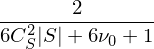

In [4]:
relaxation_rate_from_lattice_viscosity(ν_0 + C_S ** 2 * S)


and insert it into the equation for $|S|$

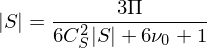

In [5]:
Seq2 = Seq.subs(ω, relaxation_rate_from_lattice_viscosity(ν_0 + C_S **2 * S ))
Seq2

This equation contains only known quantities, such that we can solve it for $|S|$.
Additionally we substitute the lattice viscosity $\nu_0$ by the original relaxation time $\tau_0$. The resulting equations get simpler using relaxation times instead of rates.

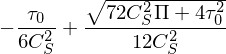

In [6]:
solveRes = sp.solve(Seq2, S)
assert len(solveRes) == 1
SVal = solveRes[0]
SVal = SVal.subs(ν_0, lattice_viscosity_from_relaxation_rate(1 / τ_0)).expand()
SVal

Knowning $|S|$ we can compute the total relaxation time using

$$\nu_{total} = \nu_0 +C_S^2 |S|$$


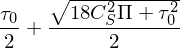

In [7]:
τ_val = 1 / (relaxation_rate_from_lattice_viscosity(lattice_viscosity_from_relaxation_rate(1/τ_0) + C_S**2 * SVal)).cancel()
τ_val

To compute $\Pi^{(neq)}$ we use the following functions:

In [8]:
def second_order_moment_tensor(function_values, stencil):
    assert len(function_values) == len(stencil)
    dim = len(stencil[0])
    return sp.Matrix(dim, dim, lambda i, j: sum(c[i] * c[j] * f for f, c in zip(function_values, stencil)))


def frobenius_norm(matrix, factor=1):
    return sp.sqrt(sum(i*i for i in matrix) * factor)

In the next cell we construct equations that take an standard relaxation rate $\omega_0$ and compute a new relaxation rate $\omega_{total}$ according to the Smagorinksy model, using `τ_val` computed above

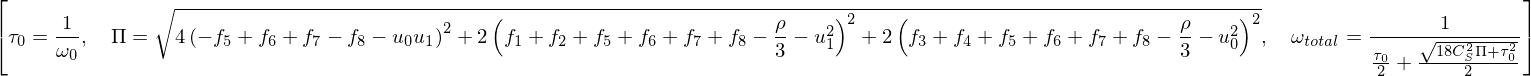

In [9]:
def smagorinsky_equations(ω_0, ω_total, method):
    f_neq = sp.Matrix(method.pre_collision_pdf_symbols) - method.get_equilibrium_terms()
    return [sp.Eq(τ_0, 1 / ω_0),
            sp.Eq(Π, frobenius_norm(second_order_moment_tensor(f_neq, method.stencil), factor=2)),
            sp.Eq(ω_total, 1 / τ_val)]


smagorinsky_equations(ω_0, ω_total, create_lb_method())

## 2) Application: Channel flow

Next we modify a *lbmpy* scenario to use the Smagorinsky model. 
We create a MRT method, where we fix all relaxation rates except the relaxation rate that controls the viscosity.

In [10]:
method = create_lb_method(method='mrt', stencil='D2Q9', force=(1e-6, 0),
                          relaxation_rates=[0, 0, ω, 1.9, 1.9])
method

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$0$
$x$,$u_{0}$,$0$
$y$,$u_{1}$,$0$
$3 x^{2} - 2$,$- \rho + 3 u_{0}^{2}$,$\omega$
$3 y^{2} - 2$,$- \rho + 3 u_{1}^{2}$,$\omega$
$x y$,$u_{0} u_{1}$,$\omega$
$3 x^{2} y - 2 y$,$- u_{1}$,$1.9$
$3 x y^{2} - 2 x$,$- u_{0}$,$1.9$
$9 x^{2} y^{2} - 6 x^{2} - 6 y^{2} + 4$,$\rho - 3 u_{0}^{2} - 3 u_{1}^{2}$,$1.9$


Only the collision rule has to be changed. Thus we first construct the collision rule, add the Smagorinsky equations and create a normal scenario from the modified collision rule.

In [11]:
collision_rule = create_lb_collision_rule(lb_method=method)
collision_rule = collision_rule.new_with_substitutions({ω: ω_total})

collision_rule.subexpressions += smagorinsky_equations(ω, ω_total, method)
collision_rule.topological_sort(sort_subexpressions=True, sort_main_assignments=False)
collision_rule

$$vel0Term \leftarrow f_{4} + f_{6} + f_{8}$$
$$vel1Term \leftarrow f_{1} + f_{5}$$
$$\rho \leftarrow f_{0} + f_{2} + f_{3} + f_{7} + vel0Term + vel1Term$$
$$u_{0} \leftarrow - f_{3} - f_{5} - f_{7} + vel0Term + 5.0 \cdot 10^{-7}$$
$$u_{1} \leftarrow - f_{2} + f_{6} - f_{7} - f_{8} + vel1Term$$
$$u0Mu1 \leftarrow u_{0} - u_{1}$$
$$u0Pu1 \leftarrow u_{0} + u_{1}$$
$$f_{eq common} \leftarrow 1.0 \rho - 1.12987012987013 u_{0}^{2} - 1.12987012987013 u_{1}^{2}$$
$$\tau_{0} \leftarrow \frac{1}{\omega}$$
$$\Pi \leftarrow \sqrt{4 \left(- f_{5} + f_{6} + f_{7} - f_{8} - u_{0} u_{1}\right)^{2} + 2 \left(f_{1} + f_{2} + f_{5} + f_{6} + f_{7} + f_{8} - \frac{\rho}{3} - u_{1}^{2}\right)^{2} + 2 \left(f_{3} + f_{4} + f_{5} + f_{6} + f_{7} + f_{8} - \frac{\rho}{3} - u_{0}^{2}\right)^{2}}$$
$$\omega_{total} \leftarrow \frac{1}{\frac{\tau_{0}}{2} + \frac{\sqrt{18 C_{S}^{2} \Pi + \tau_{0}^{2}}}{2}}$$


In the next cell the collision rule is simplified by extracting common subexpressions

In [12]:
from pystencils.simp import sympy_cse
#collision_rule = sympy_cse(collision_rule)

A channel scenario can be created from a modified collision rule:

In [13]:
ch = create_channel((300, 100), force=1e-6, collision_rule=collision_rule,
                    kernel_params={"C_S": 0.12, "omega": 1.999})

In [14]:
#show_code(ch.ast)

In [15]:
ch.run(5000)

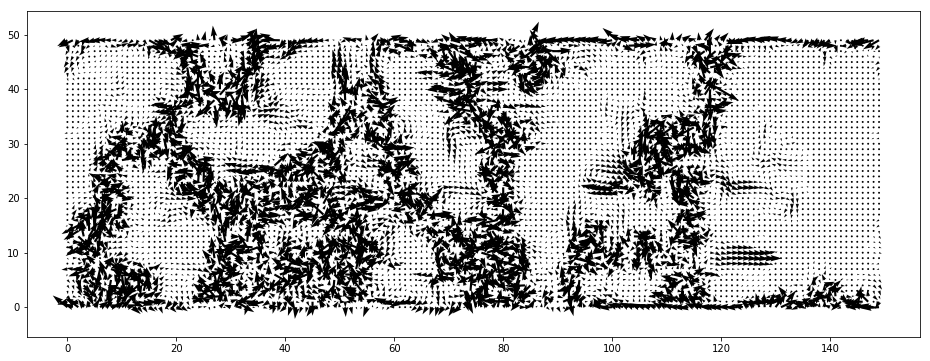

In [16]:
plt.vector_field(ch.velocity[:, :])
np.max(ch.velocity[:, :])

## Appendix: Strain rate tensor formula from Chapman Enskog

The connection between $S_{ij}$ and $\Pi_{ij}^{(neq)}$ can be seen using a Chapman Enskog expansion. Since *lbmpy* has a module that automatically does this expansions we can have a look at it:

In [17]:
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis, CeMoment
from lbmpy.chapman_enskog.chapman_enskog import remove_higher_order_u
compressible_model = create_lb_method(stencil="D2Q9", compressible=True)
incompressible_model = create_lb_method(stencil="D2Q9", compressible=False)

ce_compressible = ChapmanEnskogAnalysis(compressible_model)
ce_incompressible = ChapmanEnskogAnalysis(incompressible_model)

The Chapman Enskog analysis yields expresssions for the moment  

$\Pi = \Pi^{(eq)} + \epsilon \Pi^{(1)} +  \epsilon^2 \Pi^{(2)} \cdots$
and the strain rate tensor is related to $\Pi^{(1)}$. However the best approximation we have for $\Pi^{(1)}$ is 
$\Pi^{(neq)}$. For details, see the paper "Shear stress in lattice Boltzmann simulations" by Krüger, Varnik and Raabe from 2009.

Lets look at the values of $\Pi^{(1)}$ obtained from the Chapman enskog expansion:

In [18]:
Π_1_xy = CeMoment("\\Pi", moment_tuple=(1,1), superscript=1)
Π_1_xx = CeMoment("\\Pi", moment_tuple=(2,0), superscript=1)
Π_1_yy = CeMoment("\\Pi", moment_tuple=(0,2), superscript=1)
components = (Π_1_xx, Π_1_yy, Π_1_xy)

Π_1_xy_val = ce_compressible.higher_order_moments[Π_1_xy]
Π_1_xy_val

    2                                                    2          ρ⋅D(u_0)  
ρ⋅u₀ ⋅D(u_1) + 2⋅ρ⋅u₀⋅u₁⋅D(u_0) + 2⋅ρ⋅u₀⋅u₁⋅D(u_1) + ρ⋅u₁ ⋅D(u_0) - ──────── -
                                                                       3      
──────────────────────────────────────────────────────────────────────────────
                                                           ω₀                 

 ρ⋅D(u_1)     2                  2       
 ──────── + u₀ ⋅u₁⋅D(rho) + u₀⋅u₁ ⋅D(rho)
    3                                    
─────────────────────────────────────────
                                         

This term has lots of higher order error terms in it. We assume that $u$ is small in lattice coordinates, so if we neglect all terms in $u$ that are quadratic or higher we get:

In [19]:
remove_higher_order_u(Π_1_xy_val.expand())

  ρ⋅D(u_0)   ρ⋅D(u_1)
- ──────── - ────────
    3⋅ω₀       3⋅ω₀  

Putting these steps together into a function, we can display them for the different cases quickly:

In [20]:
def get_Π_1(ce_analysis, component):
    val = ce_analysis.higher_order_moments[component]
    return remove_higher_order_u(val.expand())

Compressible case:

In [21]:
tuple(get_Π_1(ce_compressible, Pi) for Pi in components) 

⎛-2⋅ρ⋅D(u_0)   -2⋅ρ⋅D(u_1)     ρ⋅D(u_0)   ρ⋅D(u_1)⎞
⎜────────────, ────────────, - ──────── - ────────⎟
⎝    3⋅ω₀          3⋅ω₀          3⋅ω₀       3⋅ω₀  ⎠

Incompressible case:

In [22]:
tuple(get_Π_1(ce_incompressible, Pi) for Pi in components) 

⎛2⋅u₀⋅D(rho)   2⋅D(u_0)  2⋅u₁⋅D(rho)   2⋅D(u_1)  u₀⋅D(rho)   u₁⋅D(rho)   D(u_0
⎜─────────── - ────────, ─────────── - ────────, ───────── + ───────── - ─────
⎝    3⋅ω₀        3⋅ω₀        3⋅ω₀        3⋅ω₀       3⋅ω₀        3⋅ω₀      3⋅ω₀

)   D(u_1)⎞
─ - ──────⎟
     3⋅ω₀ ⎠

In the incompressible case has some terms $\partial \rho$ which are zero, since $\rho$ is assumed constant.

Leaving out the error terms we finally obtain:


$$\Pi_{ij}^{(neq)} \approx \Pi_{ij}^{(1)} = -\frac{2 \rho_{(0)}}{3 \omega_s} \left( \partial_i u_j + \partial_j u_i \right)$$